## import, functions and classes

In [1]:
#import the librairies for the processing
%run librairiesCNN.py

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)

#%matplotlib widget
#%matplotlib notebook

#Loading the network
from CNN_architectures import StreaksCNN


cpu


Fix random seed to make sure we get reproducible results.

In [2]:
my_seed = 12345
random.seed(my_seed)
np.random.seed(my_seed)

## PARAMETERS FOR THE DNS TEST 

In [3]:
############################# WHICH DNS TO IMPORT #########################################
# choose which DNS dataset to upload
#1-Horizontal Slice of Convection in a horizontally periodic box (by M. Plumley)
#2-Horizontal Slice of forced isotropic turbulence from JHTDB
#3-Rotating Stratified turbulence from JHTDB
yourChoice=2

############################# TRAINING SET INFORMATION ######################################
#What are the dimension of the images in the training set
CNN_width=48
CNN_height=48
overlap=24 #overlap of the interogation windows in the processing
############################## SYNTHETIC IMAGE INFORMATION ###################################
#Specify the maximum discplacement, particle sizes and particle density per interrogation 
#window to be used for the synthetic image
#Choose the final size of the synthetic image, it will rescale the DNS by cropping or interpolating
width=1024
height=1024
maxDisplacement=24# in px
particleRadius=range(2,4) #for each particle
gaussianBlurRadius=1
particleDensity=range(2,10) #per image
############################ SAVING DATA ####################################################
#If you want to save the images, set recordImage=True and specify the location and name 
#of the saved files. Make sure the directory DATASETfromDNS exist 
saveImage=False
folder='data/'
imageFile='dataset_JN'

## LOAD CONVOLUTIONAL NETWORK 

In [4]:
file_net = 'networks/network_grayscale_gradient_n=1M'
h5f = h5py.File(('%s_data.h5' % file_net), 'r')

testImages = h5f['validationImages'][()]
testData = h5f['validationData'][()]
scale = h5f['scale'][()]
mean = h5f['mean'][()]
windowSize = h5f['windowSize'][()]
n_ensemble_members = h5f['n_ensemble_members'][()]
filter_size = h5f['filter_size'][()]
padding = h5f['padding'][()]
h5f.close()

net_ensemble = []
for n in range(n_ensemble_members):
    f_output_name = '%s_%d.pytorch' % (file_net, n)
    net_ensemble.append(StreaksCNN(winSz = windowSize, \
                                   filtSz = filter_size, \
                                   convPad = padding))
    
    net_ensemble[n].load_state_dict(torch.load('%s_%d.pytorch' % (file_net, n), map_location = device))
    net_ensemble[n].to(device)
    net_ensemble[n].eval()
    
scaler = StandardScaler()
scaler.mean_ = mean
scaler.scale_ = scale

CNN_width=windowSize
CNN_height=windowSize
overlap=24

## LOAD DNS

Upload data from data/dataSetFromDNS_EPM.hdf5
Original Shape of X 192
Original Shape of Y 192
Original Shape of U,V (192, 192)
resizing image
Resized X 1024
Resized Y 1024
Resized U,V (1024, 1024)


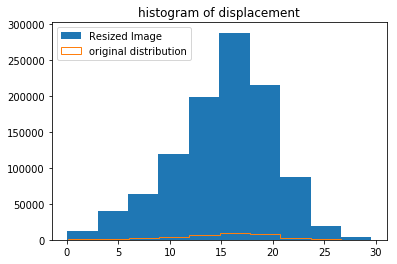

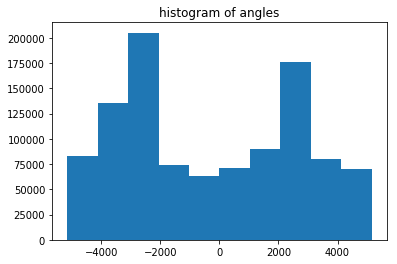

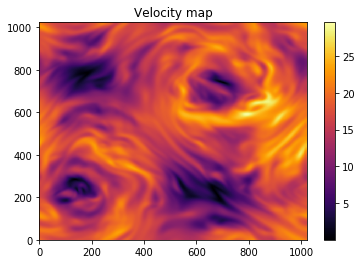

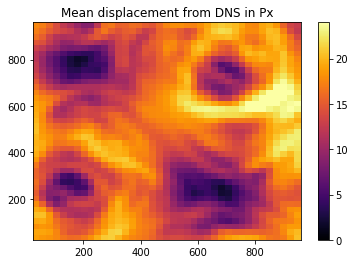

In [15]:
#IMPORT DNS
plotFigure=True

### IN PYTHON X,Y are lines,columns, the DNS must be transposed

fileName='data/dataSetFromDNS_EPM.hdf5'
f=h5py.File(fileName,'r')
#store data in array
_x00=f[('x')][:]#.value#np.array(f['x'].value)
_y00=f[('y')][:]#.value
u00=f[('u')][:]#.value
v00=f[('v')][:]#.value
#rescaleing DNS to the user defined max Displacement
u00=u00/u00.max()*maxDisplacement
v00=v00/v00.max()*maxDisplacement

f.close

###############################################################################    
originalDisplacement=np.sqrt(u00**2+v00**2)

print('Upload data from {}'.format(fileName))
print('Original Shape of X {}'.format(_x00.shape[0]))
print('Original Shape of Y {}'.format(_y00.shape[0]))
print('Original Shape of U,V {}'.format(u00.shape))


#if the desired image size is different from the original data set, we crop or interpolate
if (_x00.shape[0]!=width) or (_y00.shape[0]!=height):
    resizeImage=True
    _x=np.arange(width)
    _y=np.arange(height)
    u=np.array(resize(u00, (height,width),anti_aliasing=True))
    v=np.array(resize(v00, (height,width),anti_aliasing=True))
    

    
else:
    resizeImage=False
    _x=_x00
    _y=_y00
    u,v=u00,v00


###############################################################################

#calculate the mean displacement, angle and energy spectrum

x,y=np.meshgrid(_x,_y)
displacement=np.sqrt(u**2+v**2)
angle=np.arctan(v/u)*180/np.pi
energy=np.mean(displacement)**2
kx,Ekx,ky,Eky,k,Ek,Ek2D=getEnergySpectrum(_x,_y,displacement-displacement.mean())

originalWidth=_x00.shape[0]
originalheight=_y00.shape[0]
resizedWidth=_x.shape[0]
resizedHeight=_y.shape[0]

print('resizing image')
print('Resized X {}'.format(resizedWidth))
print('Resized Y {}'.format(resizedHeight))
print('Resized U,V {}'.format(u.shape))



xdns,ydns,displacementdns,angledns,W,H=windowAveraging(displacement,angle,CNN_width,CNN_height,overlap)



###########################     PLOT     ########################


if plotFigure:
    figure()
    title('histogram of displacement')
    if resize:
        hist(displacement.flatten(),label='Resized Image')
        hist(originalDisplacement.flatten(),histtype=u'step',label='original distribution')
    else:
        hist(originalDisplacement.flatten(),label='Resized Image')
    legend()

    figure()
    title('histogram of angles')
    hist(angle.flatten()*180/np.pi)

    show()

    figure()
    title('Velocity map')
    p=pcolormesh(x,y,displacement,cmap='inferno')
    colorbar(p)
    #xlim((0,1024))
    #ylim((0,512))
    show()

    figure()
    title('Mean displacement from DNS in Px')
    pmean=pcolormesh(xdns,ydns,displacementdns,vmin=0,vmax=maxDisplacement,cmap='inferno')
    colorbar(pmean)
    #xlim((0,1024))
    #ylim((0,512))
    show()
    

## Generate images from DNS:



(1048576,)
(1048576,)
(1048576,)
Finished, took 1.9592s. 1.53 images/sec.


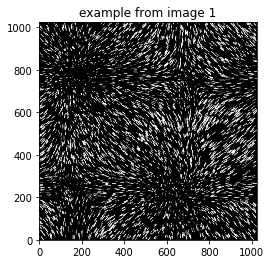

In [8]:
#generate count images
nImages=3
start_time = time.time()
myImagesGenerator = DNS_StreakImageGenerator(x,y,u,v,particleDensity,particleRadius,CNN_width,CNN_height)
myImages= myImagesGenerator.generate(count = nImages, sigma = 1, truncate = 2)
elapsed_time = time.time() - start_time
print("Finished, took {:.4f}s. {:.2f} images/sec.".format(elapsed_time, \
        nImages / elapsed_time))
 
    
    
#plot one of images
iImage=1
figure()
title('example from image {}'.format(str(iImage)))
gray()
imshow(myImages[iImage,0,:,:],origin='lower')


im=Image.fromarray(myImages[iImage,0,:,:])


#saving images in hdf5 file
if saveImage:
    #export data in HF5 file
    import h5py
    fileName= folder+ imageFile + '.hdf5'
    h=h5py.File(fileName,'w')
    h.create_dataset('x',data=x)
    h.create_dataset('y',data=y)
    h.create_dataset('u',data=u)
    h.create_dataset('v',data=v)
    h.create_dataset('images',data=myImages)
    h.close()
    
from matplotlib.pyplot import *
    
imsave('dnsImage.png', myImages[1,0,:,:])


## Apply the CNN to the batch of synthetic images

In [9]:
applyEnsemble=True #Apply the N networks to the image , 
#if False, apply one network only
n=3 #Network from the ensemble to use

_xcnnConcatenated,_ycnnConcatenated,splittedImages,Nh,Nw =\
splitWindows(myImages,CNN_width,CNN_height,overlap)

start_time=time.time()
predictionEnsemble=np.zeros((n_ensemble_members,splittedImages.shape[1],2))
predictionSingle=np.zeros((splittedImages.shape[0],splittedImages.shape[1],2))
prediction=np.zeros((splittedImages.shape[0],splittedImages.shape[1],2))
displacementcnn=np.zeros((splittedImages.shape[0],Nh,Nw))
anglecnn=np.zeros((splittedImages.shape[0],Nh,Nw))


for iImage in range(nImages):  
    imagesTOprocess=splittedImages[iImage,:,:,:,:]
    xSet = torch.from_numpy(np.array(imagesTOprocess) / 255).type(torch.FloatTensor)

    if applyEnsemble:
        print('Processing with Ensemble image #{}'.format(iImage))
        for n in range(n_ensemble_members):
            net = net_ensemble[n]
            net.eval()
            val_outputs = net(xSet) 
            if 'cuda' in device.type:
                val_outputs = net_outputs.cpu()

            predictionEnsemble[n,:,:]=scaler.inverse_transform(val_outputs.data.numpy())
            prediction[iImage,:,:] += predictionEnsemble[n,:,:]

        prediction /= n_ensemble_members
    
    else:    
        print('Processing with only network #: {} image # {}'.format(n,iImage))        
        net = net_ensemble[n]
        net.eval()
        # Forward pass
        val_outputs = net(xSet)
        if 'cuda' in device.type:
            val_outputs = net_outputs.cpu()

        prediction[iImage,:,:]=scaler.inverse_transform(val_outputs.data.numpy())
        


    displacementcnn[iImage,:,:]=np.reshape(prediction[iImage,:,0],(Nh,Nw))
    anglecnn[iImage,:,:]=np.reshape(prediction[iImage,:,1],(Nh,Nw))
    xcnn=np.reshape(np.array(_xcnnConcatenated),(Nh,Nw))
    ycnn=np.reshape(np.array(_ycnnConcatenated),(Nh,Nw))
    _xcnn=xcnn[:,0]
    _ycnn=ycnn[0,:]


elapsed_time = time.time() - start_time
print("Testing finished, took {:.4f}s. {:.2f} images/sec.".format(elapsed_time, \
                            n_ensemble_members / elapsed_time))

Processing with Ensemble image #0
Processing with Ensemble image #1
Processing with Ensemble image #2
Testing finished, took 11.5724s. 0.86 images/sec.


## ERROR ON THE DISPLACEMENT and ANGLE

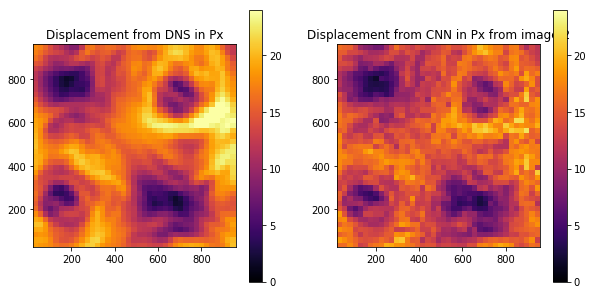

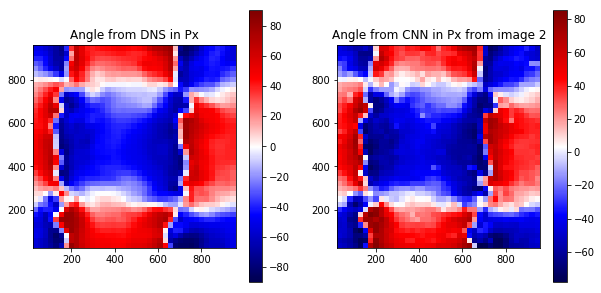

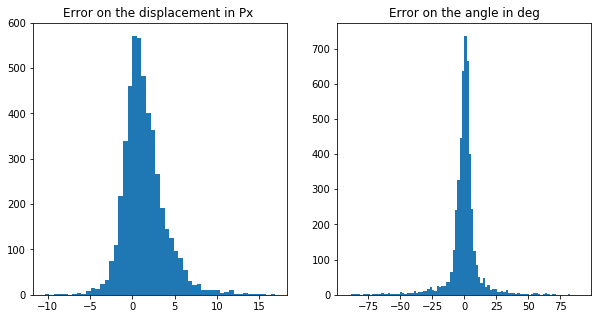

In [13]:
errorDisplacement=[]
errorAngle=[]
errorSpectrum=[]
for iImage in range(nImages):
    errorDisplacement.append(displacementdns\
                             -displacementcnn[iImage,:,:])
    errorAngle.append(angledns-anglecnn[iImage,:,:])

figure(figsize=(10,5))
subplot(1,2,1)
title('Displacement from DNS in Px')
pdispdns=pcolormesh(xdns,ydns,displacementdns,vmin=0,vmax=maxDisplacement,cmap='inferno')
colorbar(pdispdns)
axis('scaled')
subplot(1,2,2)
#imshow(myImages[iImage,0,:,:], origin='lower')


title('Displacement from CNN in Px from image {}'.format(str(iImage)))
pdispcnn=pcolormesh(xdns,ydns,np.mean(displacementcnn,axis=0),vmin=0,vmax=maxDisplacement,cmap='inferno')
axis('scaled')
colorbar(pdispcnn)
show()

figure(figsize=(10,5))
subplot(1,2,1)
title('Angle from DNS in Px')
pangdns=pcolormesh(xdns,ydns,angledns,vmin=-90,vmax=90,cmap='seismic')
colorbar(pangdns)
axis('scaled')

subplot(1,2,2)
title('Angle from CNN in Px from image {}'.format(str(iImage)))
panglecnn=pcolormesh(xdns,ydns,np.mean(anglecnn,axis=0),cmap='seismic')
colorbar(panglecnn)
axis('scaled')
show()


figure(figsize=(10,5))
subplot(1,2,1)
title('Error on the displacement in Px ')
h1=hist(np.array(errorDisplacement).flatten(),50, density=False)

subplot(1,2,2)
title('Error on the angle in deg')
h2=hist(np.array(errorAngle).flatten(),100, range=(-90,90),density=False)



## Compare the DNS-raw Streaks Image with streaks predicted by CNN (yellow) and space average DNS over the same interogation windows.

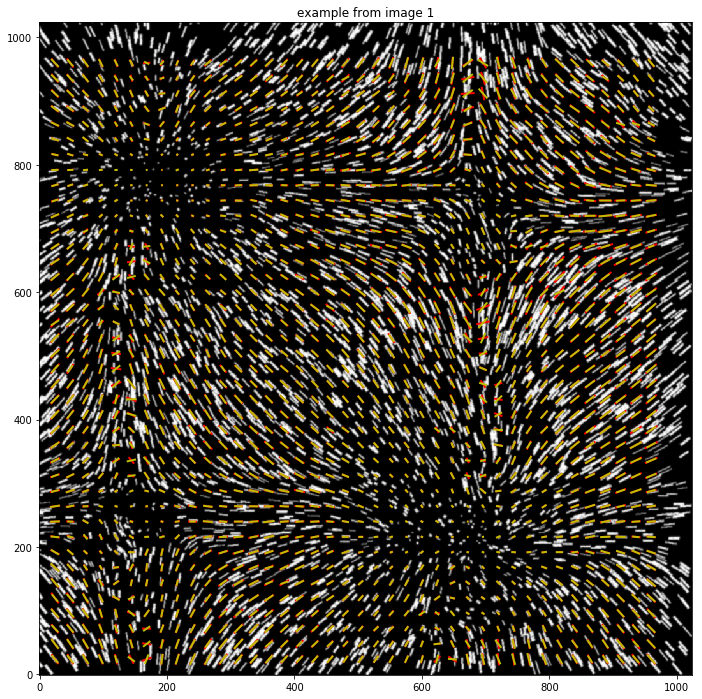

In [14]:
#select an image to compare the results to 
iImage=1


plotdns=True
plotcnn=True
showimage=True


fig=figure(figsize=(12,12))
ax = fig.add_subplot(1,1,1)
ax.set_title('example from image {}'.format(str(iImage)))
if showimage==True:
#gray()
    #imshow(np.flipud(myImages[iImage,0,:,:]))
    imshow((myImages[iImage,0,:,:]),origin='lower')

#Streas from DNS
if plotdns==True:
    xminus = xdns.flatten() - np.cos( angledns.flatten() * np.pi / 180) \
    * displacementdns.flatten() / 2.
    xplus = xdns.flatten() + np.cos( angledns.flatten() * np.pi / 180) \
    * displacementdns.flatten() / 2.

    yminus = ydns.flatten() - np.sin( angledns.flatten() * np.pi / 180) \
    * displacementdns.flatten() / 2.
    yplus = ydns.flatten() + np.sin( angledns.flatten() * np.pi / 180) \
    * displacementdns.flatten() / 2.

    xydns = np.array(([xminus, yminus], [xplus, yplus]));

    
#    imStreaks = Image.new('L', (x.shape[0],y.shape[1]),(0))
#    draw = ImageDraw.Draw(imStreaks)
       
            
    
    for i in range(0,xydns.shape[2]):

        linedns = patches.Polygon(xydns[:,:,i], color = 'r', linewidth = 2)
        ax.add_patch(linedns)
        #draw.line(((xydns[i,],_y0[indx[i]]),(_x1[i],_y1[i])), fill=(255), width=2)   
    
#Streaks from CNN
if plotcnn==True:
    x0 = xcnn.flatten() - np.cos( np.mean(anglecnn,axis=0).flatten() * np.pi / 180) \
    * np.mean(displacementcnn,axis=0).flatten() / 2.
    x1 = xcnn.flatten() + np.cos( np.mean(anglecnn,axis=0).flatten() * np.pi / 180) \
    * np.mean(displacementcnn,axis=0).flatten() / 2.

    y0 = ycnn.flatten() - np.sin( np.mean(anglecnn,axis=0).flatten() * np.pi / 180) \
    * np.mean(displacementcnn,axis=0).flatten() / 2.
    y1 = ycnn.flatten() + np.sin( np.mean(anglecnn,axis=0).flatten() * np.pi / 180) \
    * np.mean(displacementcnn,axis=0).flatten() / 2.

    xycnn = np.array(([x0, y0], [x1, y1]));


    for i in range(0,xycnn.shape[2]):

        line = patches.Polygon(xycnn[:,:,i], color = 'y', linewidth = 2)
        ax.add_patch(line)

    

    
#ax.pcolormesh(xdns,ydns,errorMap,alpha=0.4,cmap='inferno')
show()